# Lab11-1: Convolution Neural Networks
<hr>

110062802 呂宸漢


## 1. Prepare Dataset


In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
import pathlib
from sklearn.utils import shuffle

# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif', 'bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)


classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


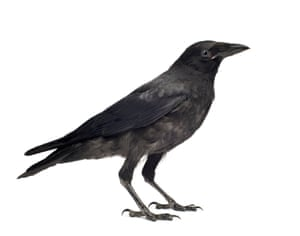

raven


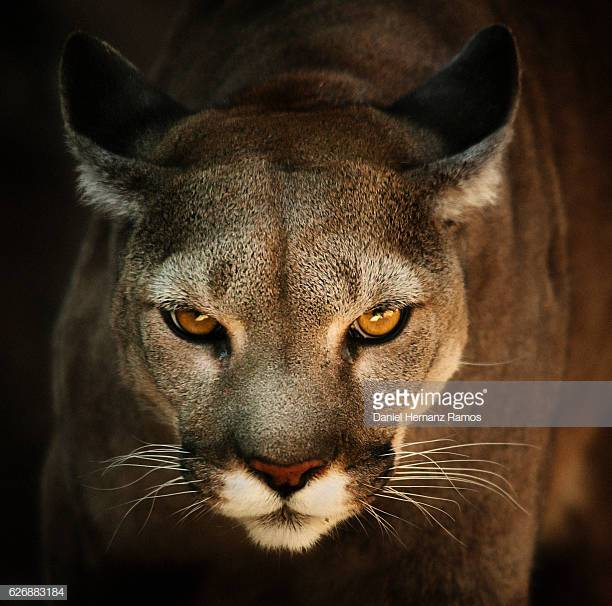

cougar


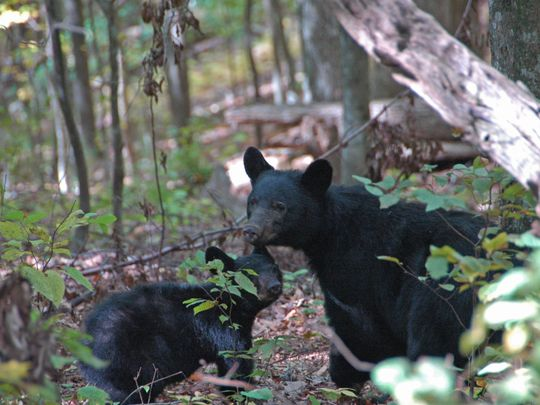

black_bear


In [3]:
import random
import IPython.display as display

# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split(os.path.sep)[-2])


In [4]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)


['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [5]:
# get the mapping dict
label_to_index = dict((name, index) for index, name in enumerate(label_names))
index_to_label = dict((index, name) for index, name in enumerate(label_names))
print(label_to_index)


{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [6]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])


First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [7]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                                                        all_image_labels, test_size=0.2, random_state=0)
print('training data: %d' % (len(img_path_train)))
print('testing data: %d' % (len(img_path_val)))


training data: 5734
testing data: 1434


In [8]:
import csv

# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open('val.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])


## 2. Create Data Loader


In [9]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


In [10]:
import tensorflow as tf


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    return img


In [11]:
import itertools
from collections import defaultdict
import time
import pandas as pd


class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300, 300, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    # Number of epochs done for each dataset
    _EPOCHS_COUNTER = defaultdict(itertools.count)

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1),
                 (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered

    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )


In [12]:
# feel free to modify these two Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 32


def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv')


def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')


dataset_train = tf.data.Dataset.range(1)\
                               .flat_map(dataset_generator_fun_train)\
                               .batch(BATCH_SIZE)

dataset_val = tf.data.Dataset.range(1)\
                             .flat_map(dataset_generator_fun_val)\
                             .batch(BATCH_SIZE)


tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[1.1451375e+01 1.0567200e-02]
 [1.1461944e+01 7.1880999e-03]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


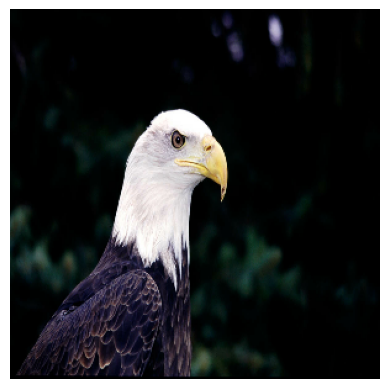

bald_eagle


In [13]:
import matplotlib.pyplot as plt

for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])


## 3. Build CNN Model


In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input,
                            outputs=top_model(base_model.output))


In [15]:
wild_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [16]:
# save the initialization of weights
wild_model.save_weights('wild_model.h5')


In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')


In [18]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def val_step(images, labels):
    predictions = wild_model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)


## 4. Train and Validate CNN Model


In [19]:
from tqdm import tqdm
import math


def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 3

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i, -1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i, -1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              val_loss.result(),
                              val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}


In [20]:
import numpy as np
import matplotlib as mpl


def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:, 0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:, 0].min()
    times[:, 0] = (times[:, 0] - min_time)
    end = max(width, (times[:, 0]+times[:, 1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))

    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps == step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l, v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")


### i. Without data transformation and pipeline optimization


In [21]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_val)


training:


100%|██████████| 180/180 [01:37<00:00,  1.84it/s]


validating:


100%|██████████| 45/45 [00:26<00:00,  1.72it/s]


Epoch 1, Loss: 4.1919, Accuracy: 34.4437, val Loss: 1.0270, val Accuracy: 70.5718
training:


100%|██████████| 180/180 [01:31<00:00,  1.98it/s]


validating:


100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


Epoch 2, Loss: 1.3094, Accuracy: 54.3600, val Loss: 0.8942, val Accuracy: 74.7559
training:


100%|██████████| 180/180 [01:35<00:00,  1.88it/s]


validating:


100%|██████████| 45/45 [00:23<00:00,  1.88it/s]

Epoch 3, Loss: 1.0273, Accuracy: 64.9983, val Loss: 0.6816, val Accuracy: 80.1953
Execution time: 357.6852596


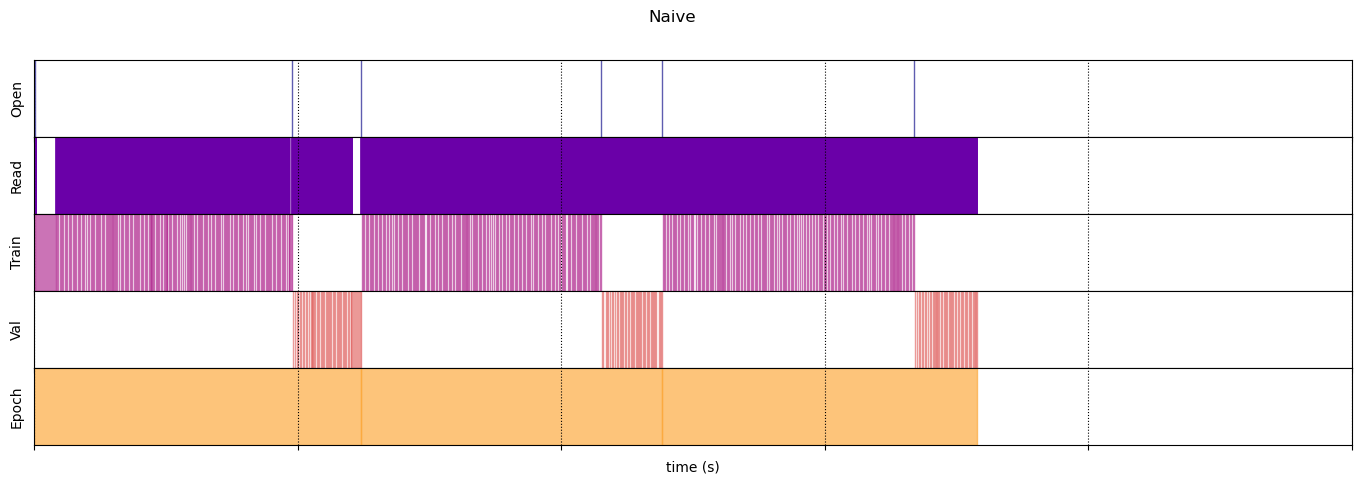

In [22]:
draw_timeline(timeline_Naive, "Naive", 500)


### ii. With data transformation

1. Shuffle the data before batching them.
2. Apply random flip (left or right), random brightness, random contrast, and standardization on training images, but only apply standardization on testing images.


In [23]:
# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

# parse testing data
@tf.function
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label


In [24]:
# TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
# Remember to define your own map functions before calling map

dataset_train_augmentation = tf.data.Dataset.range(1)\
                                            .flat_map(dataset_generator_fun_train)\
                                            .shuffle(BUFFER_SIZE)\
                                            .batch(BATCH_SIZE, drop_remainder=True)\
                                            .map(map_fun)

dataset_test_augmentation = tf.data.Dataset.range(1)\
                                           .flat_map(dataset_generator_fun_val)\
                                           .batch(BATCH_SIZE, drop_remainder=True)\
                                           .map(map_fun_test)


In [25]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(
    dataset_train_augmentation, dataset_test_augmentation)


training:


 99%|█████████▉| 179/180 [01:42<00:00,  1.74it/s]


validating:


 98%|█████████▊| 44/45 [00:20<00:00,  2.10it/s]


Epoch 1, Loss: 4.9799, Accuracy: 55.8310, val Loss: 0.5120, val Accuracy: 84.3040
training:


 99%|█████████▉| 179/180 [01:48<00:00,  1.65it/s]


validating:


 98%|█████████▊| 44/45 [00:21<00:00,  2.07it/s]


Epoch 2, Loss: 0.6286, Accuracy: 79.9756, val Loss: 0.2844, val Accuracy: 91.7614
training:


 99%|█████████▉| 179/180 [01:50<00:00,  1.63it/s]


validating:


 98%|█████████▊| 44/45 [00:20<00:00,  2.10it/s]

Epoch 3, Loss: 0.4504, Accuracy: 85.7018, val Loss: 0.2616, val Accuracy: 92.1875
Execution time: 384.6921495


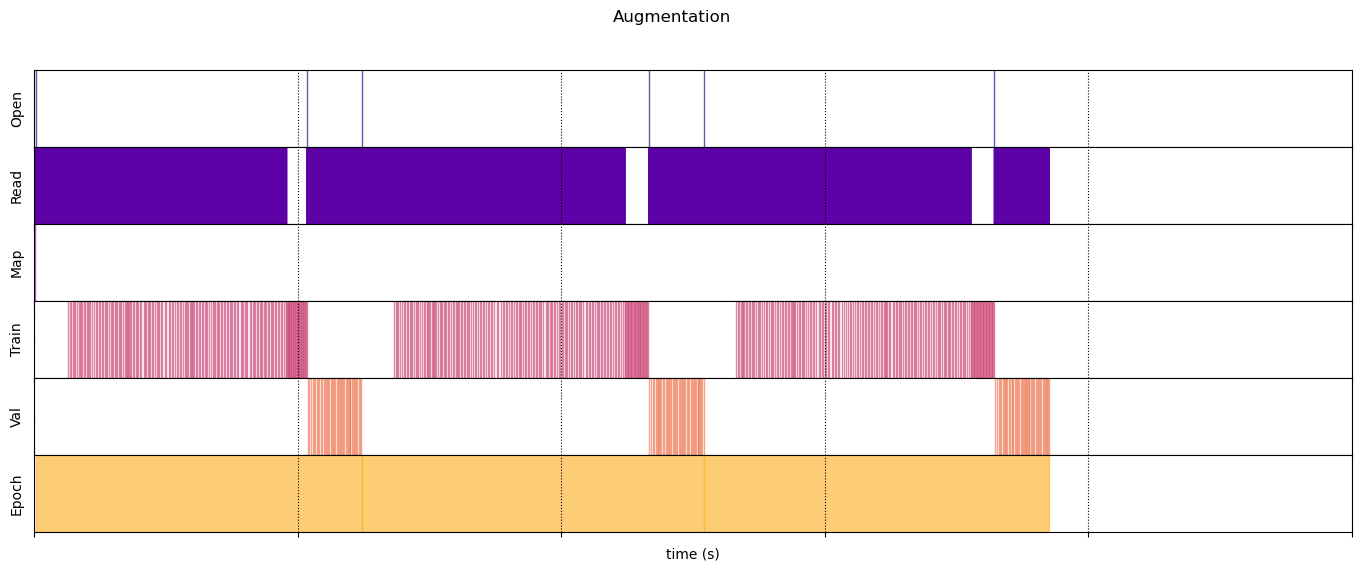

In [26]:
draw_timeline(timeline_Augmentation, "Augmentation", 500)


### iii. With data transformation and pipeline optimization

1. Shuffle the data before batching them.
2. Apply random flip (left or right), random brightness, random contrast, and standardization on training images, but only apply standardization on testing images.
3. Parallelize data extraction and mapping process.
4. Use caching and prefetch techniques to save operations and overlap executions, respectively.


In [27]:
# TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
# Remember to re-define your own map functions again to make mapping time re-calculated

dataset_train_optimized = tf.data.Dataset.range(1)\
                                         .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                         .shuffle(BUFFER_SIZE)\
                                         .batch(BATCH_SIZE, drop_remainder=True)\
                                         .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                         .cache()\
                                         .prefetch(tf.data.AUTOTUNE)

dataset_test_optimized = tf.data.Dataset.range(1)\
                                        .interleave(dataset_generator_fun_val, num_parallel_calls=tf.data.AUTOTUNE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                        .cache()\
                                        .prefetch(tf.data.AUTOTUNE)


In [28]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(
    dataset_train_optimized, dataset_test_optimized)


training:


 99%|█████████▉| 179/180 [01:31<00:00,  1.95it/s]


validating:


 98%|█████████▊| 44/45 [00:22<00:00,  1.99it/s]


Epoch 1, Loss: 5.9830, Accuracy: 51.0824, val Loss: 0.5219, val Accuracy: 86.2926
training:


 99%|█████████▉| 179/180 [00:33<00:00,  5.27it/s]


validating:


 98%|█████████▊| 44/45 [00:08<00:00,  5.41it/s]


Epoch 2, Loss: 0.7131, Accuracy: 77.7933, val Loss: 0.3221, val Accuracy: 91.9034
training:


 99%|█████████▉| 179/180 [00:37<00:00,  4.74it/s]


validating:


 98%|█████████▊| 44/45 [00:08<00:00,  5.02it/s]

Epoch 3, Loss: 0.4459, Accuracy: 85.8415, val Loss: 0.3034, val Accuracy: 90.3409
Execution time: 202.50687979999998


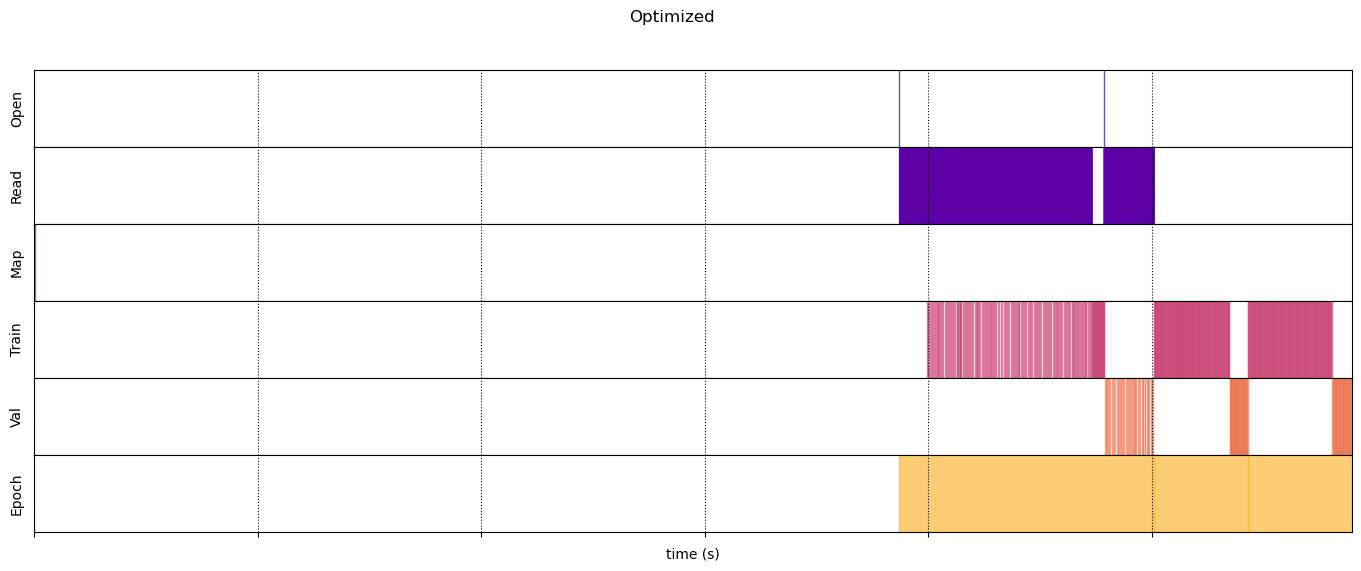

In [29]:
draw_timeline(timeline_Optimized, "Optimized", 500)


## 5. Summary

在實驗中我們將`BUFFER_SIZE`設為`1000`，`BATCH_SIZE`設為`32`，以得到較好的accuracy。

Data transformation跟pipeline optimization所在的事情分別寫在[Data Transformation](#ii-with-data-transformation)與[Pipeline Optimization](#iii-with-data-transformation-and-pipeline-optimization)。(因為連結有點不太穩定，如果沒有成功連到可以直接往上滑看4.ii與4.iii的地方。)

由下表可以看出，有做transformation的結果與original的結果相比雖然會多花一些時間，可是在training及validating accuracy都有很大的進步，分別進步了20.7%與11.99%；而在都有做transformation的情況下，有近一步做optimization的結果與沒做optimization的結果維持差不多的accuracy，可是在time consuming上減少了182.19秒，也就是可以花更少的時間達到差不多的accuracy。上述結果即可表明data transformation與pipeline optimization對training有很大的影響。

| Technique | Training Accuracy (%) | Validating Accuracy (%) | Time Consuming (sec.) |
| :---: | :---: | :---: | :---: |
| Original | 65.00 | 80.20 | 357.69 |
| With transformation | 85.70 | 92.19 | 384.69 |
| With transformation and optimization | 85.84 | 90.34 | 202.50 |

註：Training與validating accuracy皆是取第三個epoch的結果。
